In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm

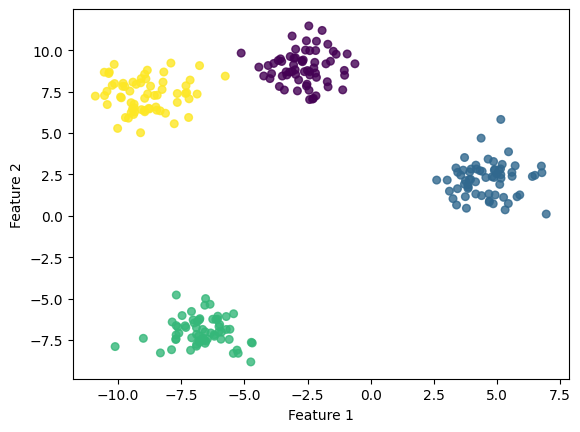

array([4.32109827e-05, 1.67907407e-03, 8.26831829e-02, 1.59997704e+01])

In [2]:
# data generation
X, Y = datasets.make_blobs(n_samples=256, centers=4, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)

# eigendecomposition for reference
inv_val, inv_vec = eigh(normalize(L_inv))
inv_val[-4:]

In [3]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))
print("unitary : ", check_unitary(expm(-1j*L)-np.eye(L.shape[0])), check_unitary(expm(-1j*L_inv)-np.eye(L.shape[0])), check_unitary(expm(-1j*L_inv_norm)-np.eye(L.shape[0])))

hermitian :  True True True
unitary :  False False False
unitary :  True True True
unitary :  False False False


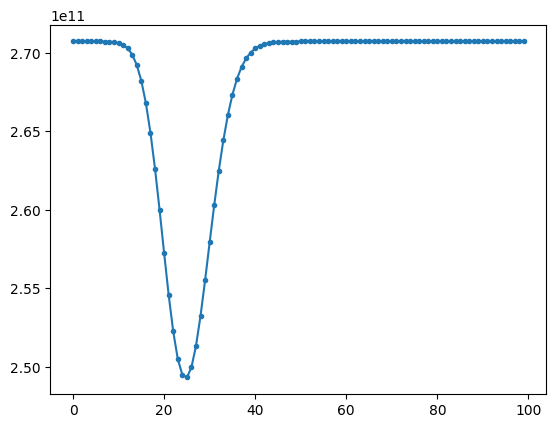

In [5]:
# convergence test
diff = []

for i in range(100):
    if i==0:
        diff.append(expm(L)-np.eye(L.shape[0]))
    else:
        comp_temp = np.linalg.matrix_power(L,i)/math.factorial(i)
        diff.append(expm(L)-comp_temp)

plt.plot(range(100),[np.linalg.norm(i) for i in diff],'.-')
plt.show()

In [45]:
L_dec = qml.pauli_decompose(L_inv_norm)

coeff = []
for elem in L_dec:
    coeff.append(str(elem).split('*')[0])

In [46]:
print(len(coeff))
print(min(coeff), max(coeff))

32275
-1.0006019355249674e-08  9.99314163575446e-08 


In [56]:
L_dec[0].scalar

0.003926871697607952

In [76]:
L_dec = qml.pauli_decompose(L_inv_norm)
L_dec_val = [i.scalar for i in L_dec]

# set a criteria
p = 75

L_dec_idx_p = []
for idx, val in enumerate(L_dec):
    if val.scalar >= np.percentile(L_dec_val, p):
        L_dec_idx_p.append(idx)

L_dec_p = [L_dec[i] for i in L_dec_idx_p]
coeff = [i.scalar for i in L_dec_p]
op = [i.base for i in L_dec_p]
H_dec = qml.Hamiltonian(coeff, op)

In [77]:
# power method with quantum circuits
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def power_circuit(params):
    qml.AngleEmbedding(params, wires=range(8)) # initial vectors
    return qml.expval(H_dec), qml.state()

# iterations
max_iter = 100
params = np.ones(8)
# params = random.uniform(0, 2 * np.pi, 8)
opt = qml.GradientDescentOptimizer(stepsize=0.3)
for i in range(max_iter):
    params = opt.step(power_circuit, params)

eig_val, eig_vec = power_circuit(params)
print(eig_val, eig_vec)

0.0041959182823165546 [ 0.35180652+0.j          0.        -0.19219278j  0.        -0.19219278j
 -0.10499539+0.j          0.        -0.19219278j -0.10499539+0.j
 -0.10499539+0.j          0.        +0.05735924j  0.        -0.19219278j
 -0.10499539+0.j         -0.10499539+0.j          0.        +0.05735924j
 -0.10499539+0.j          0.        +0.05735924j  0.        +0.05735924j
  0.0313355 +0.j          0.        -0.19219278j -0.10499539+0.j
 -0.10499539+0.j          0.        +0.05735924j -0.10499539+0.j
  0.        +0.05735924j  0.        +0.05735924j  0.0313355 +0.j
 -0.10499539+0.j          0.        +0.05735924j  0.        +0.05735924j
  0.0313355 +0.j          0.        +0.05735924j  0.0313355 +0.j
  0.0313355 +0.j          0.        -0.01711866j  0.        -0.19219278j
 -0.10499539+0.j         -0.10499539+0.j          0.        +0.05735924j
 -0.10499539+0.j          0.        +0.05735924j  0.        +0.05735924j
  0.0313355 +0.j         -0.10499539+0.j          0.        +0.057359

In [113]:
np.ones(2)/np.sqrt(2)

array([0.70710678, 0.70710678])

In [9]:
print(np.random.rand(5)-0.1)

[0.22885183 0.44578631 0.26063856 0.03559755 0.65742565]


In [114]:
# power method with quantum circuits
wires = range(8)
dev = qml.device("default.qubit", wires=wires)
H = qml.Hermitian(L_inv_norm, wires=wires)
U = expm(-1j*L_inv_norm)
# num_iter = 100

@qml.qnode(dev)
def power_method(L_inv, num_iter):
    init_amp = np.random(256)
    init_amp = expm(-1j*
    qml.StatePrep(np.ones(256)/np.sqrt(256), wires=wires)
    
    for i in range(num_iter):
        qml.QubitUnitary(U, wires=wires)
    return qml.expval(H), qml.state()

eig_val, eig_vec = power_method(H, U, num_iter)

In [118]:
dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev)
def power_method():
    qml.StatePrep(np.ones(4)/np.sqrt(4), wires=range(2))
    return qml.state()

power_method()

array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])

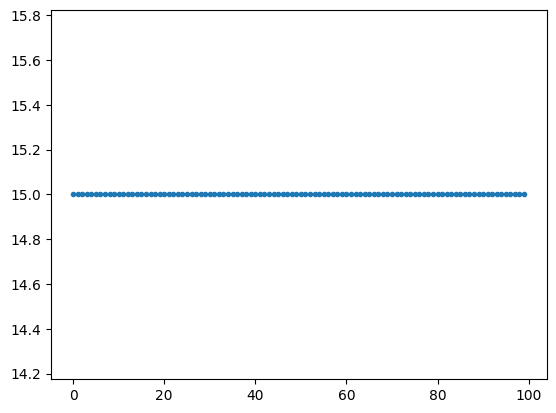

In [115]:
# convergence test
val_diff = []
for i in range(1, num_iter + 1):
    val, vec = power_method(H, U, i)
    val_diff.append(inv_val[-1]-val)

plt.plot(range(num_iter),val_diff, '.-')
plt.show()